# Load Packages, Variables

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import gc

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import gcsfs

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle


from ficc.utils.nelson_siegel_model import *
from ficc.utils.diff_in_days import *
from ficc.utils.auxiliary_functions import sqltodf


from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT, NUM_OF_DAYS_IN_YEAR
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

import sys
sys.path.append('../')
from ficc_keras_utils import *
import ficc_keras_utils
from lgbm_tools import *
from ficc_debiasing import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(f'TF Version: {tf.__version__}')

2023-07-13 20:20:49.620399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 20:20:49.786199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 20:20:49.787939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Initializing pandarallel with 16.0 cores
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
TF Version: 2.7.0


In [41]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

bq_client = bigquery.Client()
storage_client = storage.Client()

##COMMON VARIABLES
#DATA WINDOW
train_start = '2023-05-01'
train_end = '2023-06-01'
test_start = '2023-06-01'
test_end = '2023-07-01'
#MODEL PARAMETERS 
VALIDATION_SPLIT = ficc_keras_utils.VALIDATION_SPLIT
LEARNING_RATE = ficc_keras_utils.LEARNING_RATE
BATCH_SIZE = 1000 #ficc_keras_utils.BATCH_SIZE
NUM_EPOCHS = 75 #ficc_keras_utils.NUM_EPOCHS
DROPOUT = 0.01 #ficc_keras_utils.DROPOUT

##NOTEBOOK SPECIFIC VARIABLES 
TRADE_SEQUENCE_LENGTH = 2
NUM_FEATURES = 6
# target_variable = 'new_ys_diff'
# target_variable = 'new_ys' 
target_variable = 'new_ys' 

In [3]:
print(train_start ,
train_end ,
test_start ,
test_end)

2023-05-01 2023-06-01 2023-06-01 2023-07-01


# Load Data and Train NN

In [4]:
%time processed_data = load_data_from_pickle('processed_file_FULL_2023-07-12-17:22.pkl')

File available, loading pickle
CPU times: user 7.1 s, sys: 3.27 s, total: 10.4 s
Wall time: 25.3 s


In [5]:
processed_data = processed_data[~(processed_data.trade_history.apply(lambda x: x.shape) == (5,6))]

In [6]:
processed_data['trade_history'] = processed_data.trade_history.apply(lambda x: x[:,[0,2,3,4,5,6]])

In [7]:
processed_data['target_attention_features'] = processed_data['target_attention_features'].apply(lambda x: x[[0],:])

In [8]:
processed_data['target_attention_features'].iloc[0].shape

(1, 3)

## Checking data

In [9]:
processed_data.trade_date.min(), processed_data.trade_date.max()

(Timestamp('2023-05-01 00:00:00'), Timestamp('2023-07-11 00:00:00'))

In [10]:
processed_data[['yield','new_real_time_ficc_ycl']].describe()

,yield,new_real_time_ficc_ycl
count,1746702.000,1746702.000
mean,364.498,323.013
std,91.917,41.183
min,0.100,263.663
25%,307.000,297.164
50%,350.300,310.806
75%,411.000,336.136
max,9892.500,541.456


In [11]:
processed_data.reset_index(drop=True, inplace=True)

In [12]:
processed_data['new_ys_realtime'] = processed_data['yield'] - processed_data['new_real_time_ficc_ycl']
processed_data['new_ys'] = processed_data['yield'] - processed_data['new_ficc_ycl']

In [13]:
##### EXTRA DATA PREPROCESSING #####
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

ys_variants = ["max_ys", "min_ys", "max_qty", "min_ago", "D_min_ago", "P_min_ago", "S_min_ago"]
ys_feats = ["_ys", "_ttypes", "_ago", "_qdiff"]
D_prev = dict()
P_prev = dict()
S_prev = dict()

def get_trade_history_columns():
    '''
    This function is used to create a list of columns
    '''
    YS_COLS = []
    for prefix in ys_variants:
        for suffix in ys_feats:
            YS_COLS.append(prefix + suffix)
    return YS_COLS

def extract_feature_from_trade(row, name, trade):
    yield_spread = trade[0]
    ttypes = ttype_dict[(trade[3],trade[4])] + row.trade_type
    seconds_ago = trade[5]
    quantity_diff = np.log10(1 + np.abs(10**trade[2] - 10**row.quantity))
    return [yield_spread, ttypes,  seconds_ago, quantity_diff]

def trade_history_derived_features(row):
    trade_history = row.trade_history
    trade = trade_history[0]
    
    D_min_ago_t = D_prev.get(row.cusip,trade)
    D_min_ago = 9        

    P_min_ago_t = P_prev.get(row.cusip,trade)
    P_min_ago = 9
    
    S_min_ago_t = S_prev.get(row.cusip,trade)
    S_min_ago = 9
    
    max_ys_t = trade; max_ys = trade[0]
    min_ys_t = trade; min_ys = trade[0]
    max_qty_t = trade; max_qty = trade[2]
    min_ago_t = trade; min_ago = trade[5]
    
    for trade in trade_history[0:]:
        #Checking if the first trade in the history is from the same block
        if trade[5] == 0: 
            continue
 
        if trade[0] > max_ys: 
            max_ys_t = trade
            max_ys = trade[0]
        elif trade[0] < min_ys: 
            min_ys_t = trade; 
            min_ys = trade[0]

        if trade[2] > max_qty: 
            max_qty_t = trade 
            max_qty = trade[2]
        if trade[5] < min_ago: 
            min_ago_t = trade; 
            min_ago = trade[5]
            
        side = ttype_dict[(trade[3],trade[4])]
        if side == "D":
            if trade[5] < D_min_ago: 
                D_min_ago_t = trade; D_min_ago = trade[5]
                D_prev[row.cusip] = trade
        elif side == "P":
            if trade[5] < P_min_ago: 
                P_min_ago_t = trade; P_min_ago = trade[5]
                P_prev[row.cusip] = trade
        elif side == "S":
            if trade[5] < S_min_ago: 
                S_min_ago_t = trade; S_min_ago = trade[5]
                S_prev[row.cusip] = trade
        else: 
            print("invalid side", trade)
    
    trade_history_dict = {"max_ys":max_ys_t,
                          "min_ys":min_ys_t,
                          "max_qty":max_qty_t,
                          "min_ago":min_ago_t,
                          "D_min_ago":D_min_ago_t,
                          "P_min_ago":P_min_ago_t,
                          "S_min_ago":S_min_ago_t}

    return_list = []
    for variant in ys_variants:
        feature_list = extract_feature_from_trade(row,variant,trade_history_dict[variant])
        return_list += feature_list
    
    return return_list

def process_data(data): 
    data['ted-rate'] = (data['t_rate_10'] - data['t_rate_2']) * 100
    
    data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
    data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
    data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > np.log10(400))]
    data = data[data.days_to_maturity < np.log10(30000)]
    data['trade_history_sum'] = data.trade_history.parallel_apply(lambda x: np.sum(x))
    data.issue_amount = data.issue_amount.replace([np.inf, -np.inf], np.nan)
    data.dropna(inplace=True, subset=PREDICTORS+['trade_history_sum'])
    data.purpose_sub_class.fillna(0, inplace=True)
    
    return data

In [14]:
%%time
temp = processed_data[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)
YS_COLS = get_trade_history_columns()
processed_data[YS_COLS] = pd.DataFrame(temp.tolist(), index=processed_data.index)

CPU times: user 39.5 s, sys: 5.54 s, total: 45 s
Wall time: 1min 29s


In [15]:
%%time
processed_data['ttypes'] = (processed_data.last_trade_type.astype(str) + processed_data.trade_type.astype(str)).astype('category')
processed_data['diff_size'] = (processed_data.par_traded.astype(float) - processed_data.last_size).astype(np.float32)
processed_data['abs_last_yield_spread'] = np.abs(processed_data['last_yield_spread'])
processed_data['abs_diff_size'] = np.abs(processed_data['diff_size'])
processed_data['days_duration'] = (processed_data.last_calc_date - processed_data.last_settlement_date).dt.days

CPU times: user 802 ms, sys: 27.4 ms, total: 829 ms
Wall time: 845 ms


In [16]:
%%time
processed_data['trade_history_sum'] = processed_data.trade_history.parallel_apply(lambda x: np.sum(x))
processed_data = processed_data.dropna(subset=['trade_history_sum'])
processed_data.purpose_sub_class.fillna(0, inplace=True)

CPU times: user 12.5 s, sys: 3.52 s, total: 16 s
Wall time: 17.6 s


In [17]:
# for col in NON_CAT_FEATURES:
#     print(col + ':' + str(train_dataframe[col].isna().sum()))

In [18]:
for col in ['new_ficc_ycl', 'yield_spread']:
    if col in NON_CAT_FEATURES:
        NON_CAT_FEATURES.remove(col)
    if col in PREDICTORS:
        PREDICTORS.remove(col)
        
for col in ['rating']:
    if col in CATEGORICAL_FEATURES:
        CATEGORICAL_FEATURES.remove(col)
    if col in PREDICTORS:
        PREDICTORS.remove(col)

In [19]:
processed_data = process_data(processed_data)

In [20]:
additional_features = ['ttypes', 'diff_size', 'abs_last_yield_spread', 'abs_diff_size', 'days_duration']
YS_COLS = ['max_ys_ys', 'max_ys_ttypes', 'max_ys_ago', 'max_ys_qdiff', 'min_ys_ys', 'min_ys_ttypes', 'min_ys_ago', 'min_ys_qdiff', 'max_qty_ys', 'max_qty_ttypes', \
           'max_qty_ago', 'max_qty_qdiff', 'min_ago_ys', 'min_ago_ttypes', 'min_ago_ago', 'min_ago_qdiff', 'D_min_ago_ys', 'D_min_ago_ttypes', 'D_min_ago_ago', 'D_min_ago_qdiff',\
           'P_min_ago_ys', 'P_min_ago_ttypes', 'P_min_ago_ago', 'P_min_ago_qdiff', 'S_min_ago_ys', 'S_min_ago_ttypes', 'S_min_ago_ago', 'S_min_ago_qdiff']
    
for col in YS_COLS:
    if 'ttypes' in col and col not in PREDICTORS:
        PREDICTORS.append(col)
        CATEGORICAL_FEATURES.append(col)
    elif col not in PREDICTORS:
        NON_CAT_FEATURES.append(col)
        PREDICTORS.append(col)
        
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')
    
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')
    
for col in ['new_ficc_ycl', 'new_real_time_ficc_ycl']:     
    if col not in PREDICTORS:
        PREDICTORS.append(col)
        NON_CAT_FEATURES.append(col)
        
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

incorporated_state_code
trade_type
purpose_class
max_ys_ttypes
min_ys_ttypes
max_qty_ttypes
min_ago_ttypes
D_min_ago_ttypes
P_min_ago_ttypes
S_min_ago_ttypes


In [21]:
%%time

processed_data['trade_history_shortened'] = processed_data['trade_history'].apply(lambda x: x[:TRADE_SEQUENCE_LENGTH])

CPU times: user 1.41 s, sys: 101 ms, total: 1.51 s
Wall time: 1.6 s


In [22]:
%%time

processed_data['trade_history_fixed'] = processed_data['trade_history_shortened'].apply(lambda x: x[::-1, :])

CPU times: user 1.58 s, sys: 152 ms, total: 1.73 s
Wall time: 1.88 s


In [23]:
processed_data.trade_date.min(), processed_data.trade_date.max(), len(processed_data)

(Timestamp('2023-05-01 00:00:00'), Timestamp('2023-07-11 00:00:00'), 1590785)

In [24]:
train_filter = (processed_data.trade_date < train_end) & (processed_data.trade_date >= train_start)
test_filter = (processed_data.trade_date >= test_start) & (processed_data.trade_date <test_end)
                                                            
train_dataframe = processed_data[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

test_dataframe = processed_data[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

print('Training data start: {}, end: {}'.format(train_dataframe.trade_date.min(),train_dataframe.trade_date.max()))
print('Test data start: {}, end: {}'.format(test_dataframe.trade_date.min(),test_dataframe.trade_date.max()))

Training data start: 2023-05-01 00:00:00, end: 2023-05-31 00:00:00
Test data start: 2023-06-01 00:00:00, end: 2023-06-30 00:00:00


In [25]:
print(train_dataframe.trade_date.min(), train_dataframe.trade_date.max(), len(train_dataframe))
print(test_dataframe.trade_date.min(), test_dataframe.trade_date.max(), len(test_dataframe))

2023-05-01 00:00:00 2023-05-31 00:00:00 705233
2023-06-01 00:00:00 2023-06-30 00:00:00 697202


In [26]:
def create_input_new(df, trade_history_col, yield_history_cols):
    global encoders
    datalist = []
    
    for col in yield_history_cols:
        datalist.append(np.stack(df[col].to_numpy()))
        
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

def generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history,
                      yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []

    ############## INPUT BLOCK ###################
    for i in range(num_yield_history):
        inputs.append(layers.Input(name=f"yield_history_input_{yield_history_cols[i]}", 
                                           shape=(yield_history_lengths[i], 1), 
                                           dtype = tf.float32))
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[num_yield_history+2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[num_yield_history]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)

    ####################################################
    
    ############## YIELD HISTORY MODEL #################
    yield_history_outputs = []
    for i in range(num_yield_history):
        yield_lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                                 activation='tanh',
                                 input_shape=(yield_history_lengths[i], 1),
                                 return_sequences = False,
                                 name=f'Yield_History_LSTM_{yield_history_cols[i]}'))

        yield_features = yield_lstm_layer(yield_history_normalizers[i](inputs[i]))
        yield_history_outputs.append(layers.Dense(25, activation='relu')(yield_features))
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(400,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_output = layers.Dense(100,activation='tanh',name='reference_hidden_3')(reference_hidden2)

    ####################################################

    feed_forward_input = layers.concatenate(yield_history_outputs+[reference_output, trade_history_output])

    hidden = layers.Dense(300,activation='relu')(feed_forward_input)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(DROPOUT)(hidden)

    hidden2 = layers.Dense(100,activation='relu')(hidden)
    hidden2 = layers.BatchNormalization()(hidden2)
    hidden2 = layers.Dropout(DROPOUT)(hidden2)
    final = layers.Dense(1)(hidden2)

    model = keras.Model(inputs=inputs, outputs=final)
    
    return model


def create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    if isinstance(yield_history_cols, str):
        num_yield_history = 1
        yield_history_cols = [yield_history_cols]
    else:
        num_yield_history = len(yield_history_cols)
    
    yield_history_lengths = [train_dataframe[x][0].shape[0] for x in yield_history_cols]
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH, 
           'yield_history_cols':yield_history_cols, 
           'yield_history_lengths':yield_history_lengths, 
           'num_yield_history':num_yield_history }
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input_new(train_dataframe.drop(val_idx, axis=0), trade_history_col, yield_history_cols)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input_new(train_dataframe.iloc[val_idx], trade_history_col, yield_history_cols)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input_new(test_dataframe, trade_history_col, yield_history_cols)
    y_test = test_dataframe[target_variable]    
    
    # Normalization layer for the yield history
    yield_history_normalizers = []
    for i in range(num_yield_history):
        yield_history_normalizers.append(Normalization(name=f'Yield_history_normalizer_{yield_history_cols[i]}'))
        yield_history_normalizers[i].adapt(x_train[i],batch_size=BATCH_SIZE)

    # Normalization layer for the trade history
    trade_history_normalizer = Normalization(name='Trade_history_normalizer')
    trade_history_normalizer.adapt(x_train[num_yield_history],batch_size=BATCH_SIZE)

    # Normalization layer for the non-categorical and binary features
    noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
    noncat_binary_normalizer.adapt(x_train[num_yield_history+2], batch_size = BATCH_SIZE)

    normalizers = {'yield_history_normalizers': yield_history_normalizers,
                  'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx

In [27]:
def create_tf_data(x_train, y_train, shuffle=False, shuffle_buffer=1):
                     
    X=()
    for x in x_train:
        X += (tf.data.Dataset.from_tensor_slices(x),)
        

    temp = tf.data.Dataset.zip((X))
    del X
    dataset = tf.data.Dataset.zip((temp,
                        tf.data.Dataset.from_tensor_slices(y_train)))
    del temp
    if shuffle:
        shuffle_buffer = int(len(x_train[0])*shuffle_buffer)
        dataset = dataset.shuffle(shuffle_buffer)
        
    return dataset

In [28]:
def train_model_new(params, normalizers, x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1):
    tf.keras.backend.clear_session()
    gc.collect()

    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    yield_history_cols = params.get('yield_history_cols')
    yield_history_lengths = params.get('yield_history_lengths')
    num_yield_history = params.get('num_yield_history')
      
    yield_history_normalizers = normalizers.get('yield_history_normalizers')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    model = generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                               yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer)
    
    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    
    fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        # time_callback,
        CSVLoggerTimeHistory(timestamp+'_training_logs_yield_history.csv', separator=",", append=False)]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError())

    history= model.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=1, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history, model



In [29]:
trade_history_col = 'trade_history_shortened'
yield_history_cols = []

In [47]:
test_dataframe_sub = test_dataframe[test_dataframe.trade_date <= '2023-06-09']

In [37]:
# params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols)
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, test_dataframe[test_dataframe.trade_date <= '2023-06-09'], trade_history_col, yield_history_cols)

TRAINING DATA: N = 634710, MIN DATE = 2023-05-01 00:00:00, MAX DATE = 2023-05-31 00:00:00
VALIDATION DATA: N = 70523, MIN DATE = 2023-05-01 00:00:00, MAX DATE = 2023-05-31 00:00:00
TEST DATA: N = 235624, MIN DATE = 2023-06-01 00:00:00, MAX DATE = 2023-06-09 00:00:00


In [38]:
for i in range(len(x_train)):
    print(x_train[i].shape)

(634710, 2, 6)
(634710, 1, 3)
(634710, 50)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)


In [42]:
results = []
predictions = []

for i in range(6):
    tf.keras.utils.set_random_seed(10)
    history, model = train_model_new(params, normalizers, x_train, y_train, x_val, y_val, True, shuffle_buffer = .75)
    pred = model.predict(x_test)
    predictions.append(pred)
    print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
    results.append([history, model])

Epoch 1/75


2023-07-13 20:52:14.298956: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - ETA: 0s - loss: 43.3767

2023-07-13 20:52:37.494526: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 36s 25ms/step - loss: 43.3767 - val_loss: 38.4564
Epoch 2/75
635/635 [==============================] - 10s 16ms/step - loss: 39.3013 - val_loss: 36.4952
Epoch 3/75
635/635 [==============================] - 10s 16ms/step - loss: 35.7607 - val_loss: 33.6945
Epoch 4/75
635/635 [==============================] - 21s 33ms/step - loss: 31.4291 - val_loss: 30.0156
Epoch 5/75
635/635 [==============================] - 10s 16ms/step - loss: 26.1148 - val_loss: 24.1065
Epoch 6/75
635/635 [==============================] - 10s 16ms/step - loss: 20.3178 - val_loss: 17.5492
Epoch 7/75
635/635 [==============================] - 10s 16ms/step - loss: 15.2547 - val_loss: 13.0123
Epoch 8/75
635/635 [==============================] - 10s 16ms/step - loss: 12.0034 - val_loss: 10.9076
Epoch 9/75
635/635 [==============================] - 21s 33ms/step - loss: 10.6560 - val_loss: 10.1099
Epoch 10/75
635/635 [==============================] - 10s 16ms/step - loss

2023-07-13 21:07:50.805015: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 0, MAE: 10.292892152361498 =========================
Epoch 1/75


2023-07-13 21:08:39.763989: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - ETA: 0s - loss: 43.3763

2023-07-13 21:09:02.645439: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 33s 29ms/step - loss: 43.3763 - val_loss: 38.4342
Epoch 2/75
635/635 [==============================] - 17s 26ms/step - loss: 39.3005 - val_loss: 36.5158
Epoch 3/75
635/635 [==============================] - 10s 16ms/step - loss: 35.7606 - val_loss: 33.6285
Epoch 4/75
635/635 [==============================] - 15s 24ms/step - loss: 31.4276 - val_loss: 29.7123
Epoch 5/75
635/635 [==============================] - 27s 43ms/step - loss: 26.1158 - val_loss: 23.9638
Epoch 6/75
635/635 [==============================] - 10s 16ms/step - loss: 20.3188 - val_loss: 17.7455
Epoch 7/75
635/635 [==============================] - 10s 16ms/step - loss: 15.2572 - val_loss: 12.6618
Epoch 8/75
635/635 [==============================] - 13s 20ms/step - loss: 12.0001 - val_loss: 10.6579
Epoch 9/75
635/635 [==============================] - 20s 30ms/step - loss: 10.6523 - val_loss: 10.0750
Epoch 10/75
635/635 [==============================] - 10s 16ms/step - loss

2023-07-13 21:25:02.301517: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 1, MAE: 10.26893368845172 =========================
Epoch 1/75


2023-07-13 21:25:50.802762: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - ETA: 0s - loss: 43.3767

2023-07-13 21:26:23.311144: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 40s 40ms/step - loss: 43.3767 - val_loss: 38.4239
Epoch 2/75
635/635 [==============================] - 10s 16ms/step - loss: 39.3019 - val_loss: 36.5338
Epoch 3/75
635/635 [==============================] - 10s 16ms/step - loss: 35.7598 - val_loss: 33.5071
Epoch 4/75
635/635 [==============================] - 10s 16ms/step - loss: 31.4275 - val_loss: 29.9712
Epoch 5/75
635/635 [==============================] - 21s 33ms/step - loss: 26.1160 - val_loss: 24.1699
Epoch 6/75
635/635 [==============================] - 10s 16ms/step - loss: 20.3182 - val_loss: 17.5455
Epoch 7/75
635/635 [==============================] - 10s 16ms/step - loss: 15.2552 - val_loss: 12.7010
Epoch 8/75
635/635 [==============================] - 10s 16ms/step - loss: 11.9960 - val_loss: 10.7558
Epoch 9/75
635/635 [==============================] - 10s 16ms/step - loss: 10.6529 - val_loss: 10.1007
Epoch 10/75
635/635 [==============================] - 21s 33ms/step - loss

2023-07-13 21:46:19.332404: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 2, MAE: 10.229404874651108 =========================
Epoch 1/75


2023-07-13 21:47:14.230977: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - ETA: 0s - loss: 43.3768

2023-07-13 21:47:39.150689: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 38s 26ms/step - loss: 43.3768 - val_loss: 38.4017
Epoch 2/75
635/635 [==============================] - 10s 15ms/step - loss: 39.3019 - val_loss: 36.5467
Epoch 3/75
635/635 [==============================] - 10s 16ms/step - loss: 35.7607 - val_loss: 33.7445
Epoch 4/75
635/635 [==============================] - 24s 38ms/step - loss: 31.4301 - val_loss: 29.6515
Epoch 5/75
635/635 [==============================] - 13s 21ms/step - loss: 26.1161 - val_loss: 23.9852
Epoch 6/75
635/635 [==============================] - 14s 22ms/step - loss: 20.3159 - val_loss: 17.5827
Epoch 7/75
635/635 [==============================] - 23s 37ms/step - loss: 15.2508 - val_loss: 13.0351
Epoch 8/75
635/635 [==============================] - 14s 22ms/step - loss: 11.9961 - val_loss: 10.8361
Epoch 9/75
635/635 [==============================] - 14s 22ms/step - loss: 10.6486 - val_loss: 10.1597
Epoch 10/75
635/635 [==============================] - 14s 22ms/step - loss

2023-07-13 22:07:46.925139: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 3, MAE: 10.27683510952816 =========================
Epoch 1/75


2023-07-13 22:08:46.940224: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - ETA: 0s - loss: 43.3763

2023-07-13 22:09:23.205920: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 44s 45ms/step - loss: 43.3763 - val_loss: 38.4226
Epoch 2/75
635/635 [==============================] - 14s 22ms/step - loss: 39.3016 - val_loss: 36.4720
Epoch 3/75
635/635 [==============================] - 13s 20ms/step - loss: 35.7602 - val_loss: 33.8184
Epoch 4/75
635/635 [==============================] - 22s 35ms/step - loss: 31.4284 - val_loss: 29.9149
Epoch 5/75
635/635 [==============================] - 11s 18ms/step - loss: 26.1159 - val_loss: 24.2159
Epoch 6/75
635/635 [==============================] - 12s 18ms/step - loss: 20.3182 - val_loss: 17.6163
Epoch 7/75
635/635 [==============================] - 10s 16ms/step - loss: 15.2494 - val_loss: 13.0048
Epoch 8/75
635/635 [==============================] - 10s 16ms/step - loss: 11.9912 - val_loss: 10.8217
Epoch 9/75
635/635 [==============================] - 24s 38ms/step - loss: 10.6531 - val_loss: 10.0613
Epoch 10/75
635/635 [==============================] - 13s 20ms/step - loss

2023-07-13 22:27:53.362216: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 4, MAE: 10.189808756059115 =========================
Epoch 1/75


2023-07-13 22:28:52.571140: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - ETA: 0s - loss: 43.3768

2023-07-13 22:29:28.019925: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 43s 44ms/step - loss: 43.3768 - val_loss: 38.4495
Epoch 2/75
635/635 [==============================] - 14s 22ms/step - loss: 39.3017 - val_loss: 36.4140
Epoch 3/75
635/635 [==============================] - 14s 22ms/step - loss: 35.7610 - val_loss: 33.5722
Epoch 4/75
635/635 [==============================] - 24s 38ms/step - loss: 31.4287 - val_loss: 29.7997
Epoch 5/75
635/635 [==============================] - 11s 18ms/step - loss: 26.1153 - val_loss: 24.1186
Epoch 6/75
635/635 [==============================] - 11s 18ms/step - loss: 20.3179 - val_loss: 17.3476
Epoch 7/75
635/635 [==============================] - 12s 18ms/step - loss: 15.2531 - val_loss: 12.5570
Epoch 8/75
635/635 [==============================] - 22s 34ms/step - loss: 12.0032 - val_loss: 10.6759
Epoch 9/75
635/635 [==============================] - 9s 15ms/step - loss: 10.6631 - val_loss: 10.1278
Epoch 10/75
635/635 [==============================] - 10s 16ms/step - loss:

2023-07-13 22:49:38.323786: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 5, MAE: 10.228989952254985 =========================


In [44]:
t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 10.293
Trial 2: 10.269
Trial 3: 10.229
Trial 4: 10.277
Trial 5: 10.190
Trial 6: 10.229
Average MAE: 10.248


In [53]:
model.save('model_no_rating')

2023-07-13 23:25:53.823106: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_no_rating/assets


INFO:tensorflow:Assets written to: model_no_rating/assets


In [45]:
train_dataframe_rmval = train_dataframe.drop(val_idx)
val_dataframe = train_dataframe.loc[val_idx]

In [48]:
tr_pred = model.predict(x_train)
train_dataframe_rmval['prediction'] = tr_pred
val_pred = model.predict(x_val)
val_dataframe['prediction'] = val_pred
ts_pred = model.predict(x_test)
test_dataframe_sub['prediction'] = ts_pred

In [49]:
train_dataframe_rmval['error'] = tr_pred.flatten() - y_train
val_dataframe['error'] = val_pred.flatten() - y_val
test_dataframe['error'] = ts_pred.flatten() - y_test

In [50]:
print(f'TRAIN MAE: {mean_absolute_error(tr_pred,y_train)}')
print(f'VAL MAE: {mean_absolute_error(val_pred, y_val)}')
print(f'TEST MAE: {mean_absolute_error(ts_pred,y_test)}')

TRAIN MAE: 7.383286326576279
VAL MAE: 8.902210017806325
TEST MAE: 10.228989952254985


In [51]:
summarize_col(train_dataframe_rmval.error, 'TRAIN SET BIAS')
summarize_col(val_dataframe.error, 'VALIDATION SET BIAS')
summarize_col(test_dataframe.error, 'TEST SET BIAS')

TRAIN SET BIAS      : -0.35, SD: 13.74, Max: 252.92, Min: -2411.98, 75%: 4.10, 25%: -4.88
VALIDATION SET BIAS : -0.41, SD: 14.20, Max: 206.32, Min: -600.43, 75%: 5.06, 25%: -6.02
TEST SET BIAS       : 1.41, SD: 18.65, Max: 428.03, Min: -2314.73, 75%: 8.02, 25%: -5.37


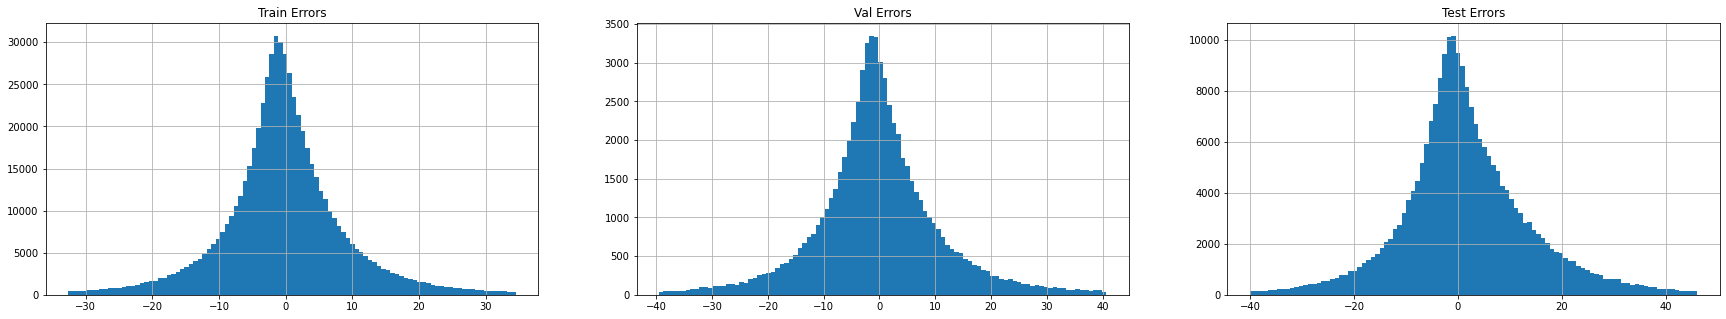

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(30,5))
for i, axes in enumerate(ax):
    if i == 0: 
        filter_column_outliers(train_dataframe_rmval, 'error', .99, .01).error.hist(ax=axes, bins = 100)
        axes.set_title('Train Errors')
    if i == 1: 
        filter_column_outliers(val_dataframe, 'error', .99, .01).error.hist(ax=axes, bins = 100)
        axes.set_title('Val Errors')
    if i == 2: 
        filter_column_outliers(test_dataframe, 'error', .99, .01).error.hist(ax=axes, bins = 100)
        axes.set_title('Test Errors')

In [60]:
%%time

train_dataframe_rmval = pd.read_pickle('train_dataframe_rmval_realtime.pkl')
val_dataframe = pd.read_pickle('val_dataframe_realtime.pkl')
test_dataframe = pd.read_pickle('test_dataframe_realtime.pkl')

CPU times: user 1min, sys: 9.06 s, total: 1min 10s
Wall time: 1min 40s


In [112]:
#sort data in chronological order because we are going to take a rolling average of errors
train_dataframe_rmval = train_dataframe_rmval.sort_values(by='trade_datetime',ascending=True).reset_index(drop=True)
val_dataframe = val_dataframe.sort_values(by='trade_datetime',ascending=True).reset_index(drop=True)
test_dataframe = test_dataframe.sort_values(by='trade_datetime',ascending=True).reset_index(drop=True)

## Adding First Published:

In [117]:
from ficc.utils.auxiliary_functions import sqltodf

In [118]:
published_datetime_df = sqltodf(f'''SELECT 
rtrs_control_number, 
first_published_datetime,
FROM
`eng-reactor-287421.auxiliary_views.materialized_trade_history`
WHERE
  yield IS NOT NULL
  AND yield > 0
  AND par_traded >= 10000
  AND trade_date >= '{train_start}'
  AND trade_date <= '{test_end}'
  AND coupon_type in (8, 4, 10, 17)
  AND capital_type <> 10
  AND default_exists <> TRUE
  AND most_recent_default_event IS NULL
  AND default_indicator IS FALSE
  AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
  AND settlement_date is not null
  ORDER BY trade_datetime desc''', bq_client)

In [119]:
test_dataframe = pd.merge(test_dataframe, published_datetime_df, on='rtrs_control_number')

## Testing debiasing on April (with masking):

In [120]:
%time error_average_bias_correction_masked = simulate_weighted_average_masked(test_dataframe, 'error', 'error', groupby_cols = ['trade_date'], window_size = 2000, weighting_method = 'simple_average', mask_large = 35, seconds_ago_mask = 120)

Ignoring trades with errors larger than 35bps in bias correction calculations.
CPU times: user 13min 6s, sys: 0 ns, total: 13min 6s
Wall time: 13min 6s


In [168]:
%time quantity_default_bias_correction_masked = simulate_weighted_average_masked(test_dataframe, 'quantity', 'error', groupby_cols = ['trade_date'], window_size = 2000, weighting_method = 'default', mask_large = 35, seconds_ago_mask = 120)

Ignoring trades with errors larger than 35bps in bias correction calculations.
CPU times: user 13min 45s, sys: 0 ns, total: 13min 45s
Wall time: 13min 45s


In [169]:
debias_series(test_dataframe['prediction'], test_dataframe[target_variable], bias_warm_start(quantity_default_bias_correction_masked, test_dataframe, 200))

Original bias: 0.451, Original MAE: 9.532, Corrected bias: 0.174, Corrected MAE: 9.277


In [124]:
debias_series(test_dataframe['prediction'], test_dataframe[target_variable], bias_warm_start(error_average_bias_correction_masked, test_dataframe, 300))

Original bias: 0.493, Original MAE: 9.891, Corrected bias: 0.186, Corrected MAE: 9.621


In [126]:
analyze_debiasing_MAE(test_dataframe,
    error_average_bias_correction,
    prediction_col='prediction',
    target_col=target_variable)

,Original MAE,Corrected MAE,Corrected - Original MAE
trade_date,,,
2023-04-03,8.475,7.978,-0.496
2023-04-04,8.566,8.346,-0.219
2023-04-05,8.296,8.310,0.014
2023-04-06,8.377,8.176,-0.201
2023-04-07,9.181,9.365,0.184
2023-04-10,8.776,8.790,0.015
2023-04-11,8.838,8.841,0.003
2023-04-12,8.771,8.735,-0.037
2023-04-13,8.591,8.607,0.016


In [119]:
analyze_debiasing_MAE(test_dataframe,
    quantity_default_bias_correction,
    prediction_col='prediction',
    target_col=target_variable)

,Original MAE,Corrected MAE,Corrected - Original MAE
trade_date,,,
2023-04-03,8.475,7.977,-0.497
2023-04-04,8.566,8.346,-0.220
2023-04-05,8.296,8.309,0.013
2023-04-06,8.377,8.174,-0.204
2023-04-07,9.181,9.396,0.214
2023-04-10,8.776,8.789,0.013
2023-04-11,8.838,8.840,0.002
2023-04-12,8.771,8.733,-0.039
2023-04-13,8.591,8.600,0.009


In [171]:
test_dataframe.set_index('trade_date').loc['2023-04-18']

,rtrs_control_number,cusip,yield,is_callable,refund_date,accrual_date,dated_date,next_sink_date,coupon,delivery_date,...,yield_curve_history_5min_12_exponential_0.25,yield_curve_history_5min_12_exponential_0.1,yield_curve_history_5min_12_exponential_0.5,new_ys,new_ys_realtime,trade_history_shortened,trade_history_fixed,prediction,error,first_published_datetime
0,2023040300000300,780870AJ0,380.300,False,NaT,2019-12-12,2019-12-12,2023-09-15,3.500,2019-12-12,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",114.544,112.074,"[[196.7763177621443, 18.0, 5.041392803192139, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [196.77631776...",141.112,29.038,2023-04-03 06:45:12
1,2023040300013400,041807DC9,437.400,True,NaT,2023-04-06,2023-04-06,2054-12-01,4.375,2023-04-06,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",159.083,158.485,"[[159.08316619252713, 89.4, 4.602059841156006,...","[[159.08316619252713, 89.4, 4.301030158996582,...",154.104,-4.381,2023-04-03 06:45:16
2,2023040300013300,661416AE7,440.600,False,NaT,2021-11-18,2021-11-18,2023-11-01,2.450,2021-11-18,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",193.569,192.821,"[[151.73281214324197, 6.2, 4.301030158996582, ...","[[170.18842308280233, 15.6, 4.740362644195557,...",187.880,-4.940,2023-04-03 06:45:15
3,2023040300029300,682001GS5,229.000,True,NaT,2019-11-07,2019-11-07,NaT,5.000,2019-11-07,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-20.942,-21.149,"[[-0.9010648244579045, -115.4, 5.1760911941528...","[[-8.721377319688742, -114.0, 4.84509801864624...",-9.083,12.066,2023-04-03 07:15:39
4,2023040300031700,799408X95,233.000,False,2025-08-01,2015-04-23,2015-04-23,2037-08-01,4.000,2015-04-23,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-21.794,-23.398,"[[-9.706116245099906, -119.0, 7.17609119415283...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-9.706116245...",-22.331,1.067,2023-04-03 07:19:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583385,2023042809797600,885528JV2,426.500,True,NaT,2023-05-18,2023-05-01,2049-02-15,4.250,2023-05-18,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",140.191,143.717,"[[132.4171362313428, 74.6, 4.653212547302246, ...","[[133.81713623134277, 76.0, 4.653212547302246,...",147.719,4.002,2023-04-28 17:11:09
583386,2023042809847200,45130ABU8,401.200,True,NaT,2023-04-27,2023-04-27,2044-08-15,4.000,2023-04-27,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-6.348,-5.290,"[[-5.90382830327178, 34.2, 4.301030158996582, ...","[[7.296171696728322, 47.4, 5.290034770965576, ...",-3.285,2.004,2023-04-28 17:13:46
583387,2023042809845800,228129YP1,325.800,False,NaT,2002-02-19,2002-02-01,NaT,0.000,2002-02-19,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",48.737,52.239,"[[57.813793028952546, -14.2, 4.176091194152832...","[[35.8137930289526, -36.2, 4.176091194152832, ...",52.179,-0.060,2023-04-28 17:13:25
583388,2023042809890200,62412PBQ8,427.100,True,NaT,2020-10-29,2020-10-29,2051-12-01,4.000,2020-10-29,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-11.861,-11.607,"[[-17.234553865787007, 54.5, 4.397940158843994...","[[-27.934553865787052, 43.8, 4.397940158843994...",-19.309,-7.702,2023-04-28 17:23:59


OVERALL ORIGINAL MAE: 11.98, OVERALL DEBIASED MAE: 10.51


,cusip,rtrs_control_number,first_published_datetime,trade_datetime,trade_type,quantity,prediction,new_ys_realtime,bias_correction,debiased_prediction,original_error,debiased_error
trade_date,,,,,,,,,,,,
2023-04-18,658207X34,2023041800000400,2023-04-18 06:45:10,2023-04-18 06:00:01,S,4.176,156.017,144.503,0.000,156.017,-11.514,-11.514
2023-04-18,658207X26,2023041800001000,2023-04-18 06:45:11,2023-04-18 06:00:02,S,4.176,160.535,139.603,0.000,160.535,-20.932,-20.932
2023-04-18,914026RN1,2023041800009300,2023-04-18 07:12:42,2023-04-18 07:11:59,S,5.000,28.172,24.503,16.223,11.949,-3.669,12.554
2023-04-18,914026RN1,2023041800009500,2023-04-18 07:12:42,2023-04-18 07:11:59,D,5.000,29.693,24.503,16.223,13.470,-5.190,11.033
2023-04-18,421020L22,2023041800019100,2023-04-18 07:17:08,2023-04-18 07:16:00,S,5.000,9.822,17.222,10.326,-0.504,7.400,17.726
2023-04-18,129644ZW3,2023041800019900,2023-04-18 07:18:28,2023-04-18 07:17:24,S,5.176,26.038,26.550,6.781,19.257,0.512,7.293
2023-04-18,129644ZW3,2023041800019800,2023-04-18 07:18:28,2023-04-18 07:17:24,D,5.176,28.886,26.550,6.781,22.105,-2.336,4.445
2023-04-18,117566BF5,2023041800020400,2023-04-18 07:19:13,2023-04-18 07:18:00,S,4.398,14.098,14.620,6.781,7.316,0.522,7.304
2023-04-18,65887PRR8,2023041800020500,2023-04-18 07:19:32,2023-04-18 07:18:41,S,6.077,8.930,10.033,5.104,3.826,1.102,6.207


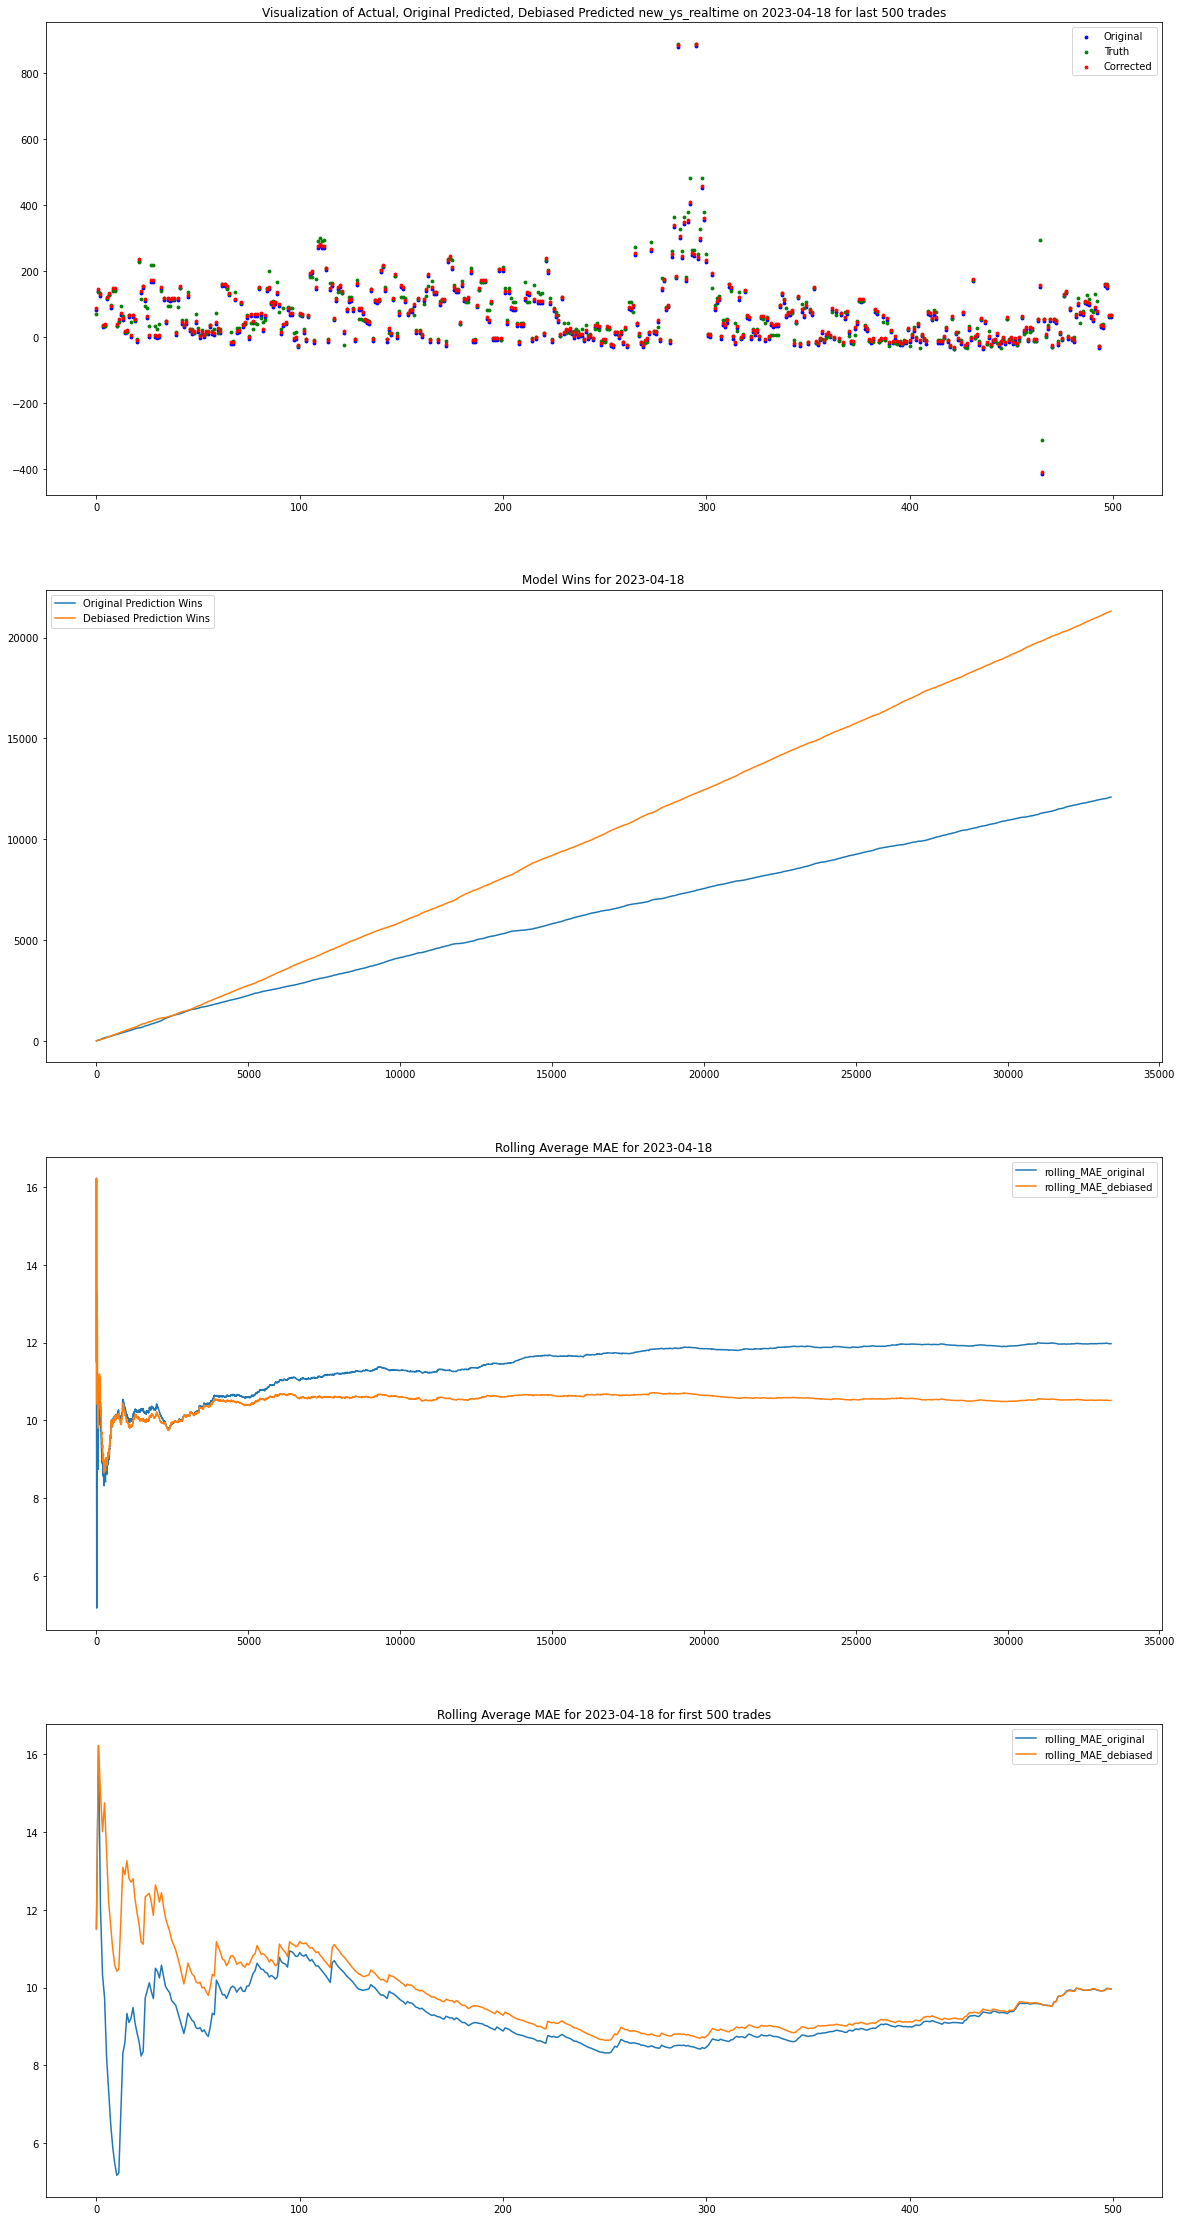

In [160]:
summary_04_18 = analyze_debiasing_day('2023-04-18', 
                      test_dataframe, 
                      error_average_bias_correction, 
                      prediction_col = 'prediction', 
                      target_col='new_ys_realtime', 
                      first_N_trades =  500, 
                      last_N_trades = 500)

summary_04_18.sort_values(by='trade_datetime', ascending=True).head(50)

## Analyzing window size and ensuring robustness to outliers:
(without masking for faster testing)

In [113]:
%time error_average_bias_correction = simulate_weighted_average(test_dataframe, 'error', 'error', groupby_cols = ['trade_date'], window_size = 2000, weighting_method = 'simple_average', mask_large = 35)
%time quantity_default_bias_correction = simulate_weighted_average(test_dataframe, 'quantity', 'error', groupby_cols = ['trade_date'], window_size = 2000, weighting_method = 'default', mask_large = 35)

Ignoring trades with errors larger than 35bps in bias correction calculations.


../../ficc_debiasing.py:128: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.multiply(errors,weights))/np.sum(weights)


CPU times: user 1min 39s, sys: 0 ns, total: 1min 39s
Wall time: 1min 39s
Ignoring trades with errors larger than 35bps in bias correction calculations.
CPU times: user 1min 58s, sys: 0 ns, total: 1min 58s
Wall time: 1min 58s


In [114]:
debias_series(test_dataframe['prediction'], test_dataframe[target_variable], np.nan_to_num(np.array(error_average_bias_correction)))

Original bias: 0.492, Original MAE: 9.891, Corrected bias: 0.203, Corrected MAE: 9.606


In [115]:
debias_series(test_dataframe['prediction'], test_dataframe[target_variable], np.nan_to_num(np.array(quantity_default_bias_correction)))

Original bias: 0.492, Original MAE: 9.891, Corrected bias: 0.224, Corrected MAE: 9.603


In [110]:
def compare_biases(date, bias_dict, df, first_N_trades = None): 
    summary = pd.DataFrame(index = df.trade_date)
    for key, value in bias_dict.items():
        summary.loc[:, key] = value
        print(f'Window Size: {key}')
        debias_series(df['prediction'], df[target_variable], value)
        print()
    if first_N_trades:    
        summary.loc[date].reset_index(drop=True).iloc[:first_N_trades].plot(figsize=(12,10))
    else: 
        summary.loc[date].reset_index(drop=True).plot(figsize=(12,10))
        
    return summary

First, simple average without masking:

In [114]:
window_sizes = [200, 500, 1000, 2000, 5000]
windowed_biases = []
for window in window_sizes:
    %time windowed_biases.append(simulate_weighted_average(test_dataframe, 'error', 'error', groupby_cols = ['trade_date'], window_size = window, weighting_method = 'simple_average', mask_large = 0))
    
bias_dict = dict(zip(window_sizes, windowed_biases))

CPU times: user 1min 20s, sys: 1.63 s, total: 1min 21s
Wall time: 1min 20s
CPU times: user 1min 23s, sys: 1.14 s, total: 1min 24s
Wall time: 1min 22s
CPU times: user 1min 19s, sys: 12.2 ms, total: 1min 19s
Wall time: 1min 19s
CPU times: user 1min 22s, sys: 0 ns, total: 1min 22s
Wall time: 1min 22s
CPU times: user 1min 30s, sys: 0 ns, total: 1min 30s
Wall time: 1min 30s


Window Size: 200
Original bias: 0.451, Original MAE: 9.531, Corrected bias: 0.002, Corrected MAE: 9.387

Window Size: 500
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.001, Corrected MAE: 9.346

Window Size: 1000
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.009, Corrected MAE: 9.331

Window Size: 2000
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.027, Corrected MAE: 9.324

Window Size: 5000
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.077, Corrected MAE: 9.321



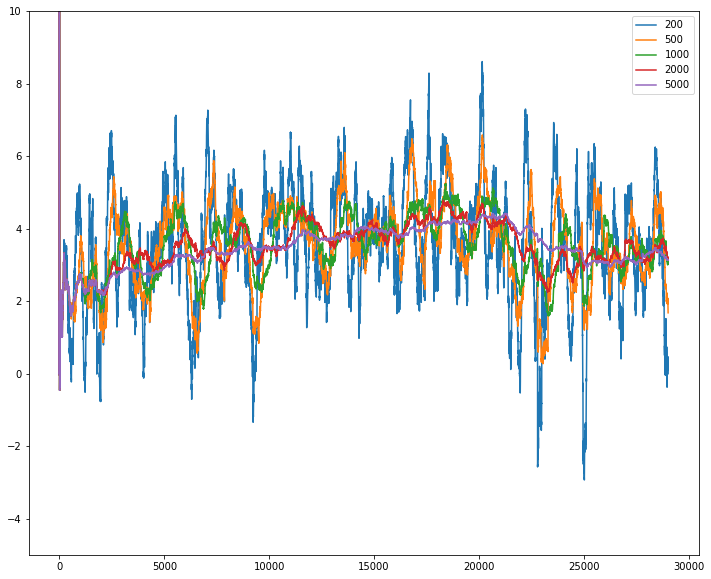

In [115]:
_ = compare_biases('2023-04-03', bias_dict, test_dataframe)
plt.ylim(-5, 10);

Simple average with masking:

In [97]:
window_sizes = [200, 500, 1000, 2000, 5000, 10000]
windowed_biases_masked = []
for window in window_sizes:
    %time windowed_biases_masked.append(simulate_weighted_average(test_dataframe, 'error', 'error', groupby_cols = ['trade_date'], window_size = window, weighting_method = 'simple_average', mask_large = 35))
    
bias_dict_masked = dict(zip(window_sizes, windowed_biases_masked))

CPU times: user 1min 22s, sys: 1.17 s, total: 1min 23s
Wall time: 1min 21s
CPU times: user 1min 24s, sys: 2.03 s, total: 1min 26s
Wall time: 1min 24s
CPU times: user 1min 20s, sys: 0 ns, total: 1min 20s
Wall time: 1min 20s
CPU times: user 1min 20s, sys: 0 ns, total: 1min 20s
Wall time: 1min 20s
CPU times: user 1min 28s, sys: 0 ns, total: 1min 28s
Wall time: 1min 28s
CPU times: user 1min 26s, sys: 0 ns, total: 1min 26s
Wall time: 1min 26s


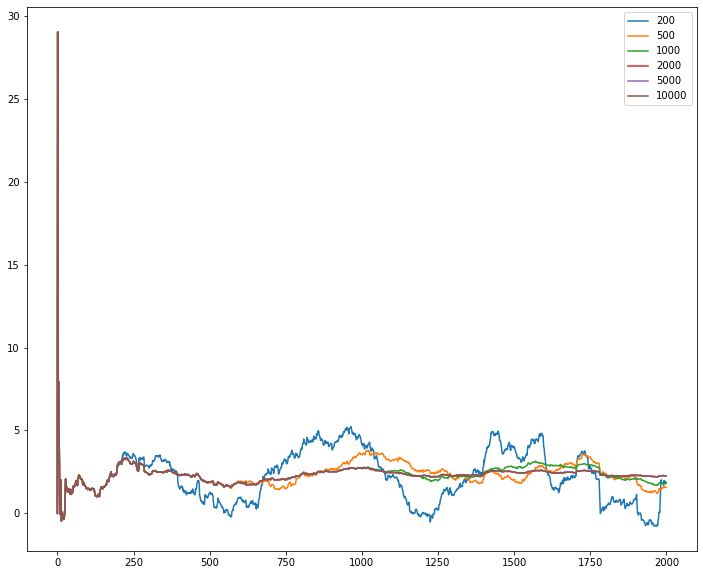

In [100]:
_ = compare_biases('2023-04-03', bias_dict_masked, test_dataframe, first_N_trades = 2000)

Window Size: 200
Original bias: 0.451, Original MAE: 9.531, Corrected bias: 0.002, Corrected MAE: 9.387

Window Size: 500
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.001, Corrected MAE: 9.346

Window Size: 1000
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.009, Corrected MAE: 9.331

Window Size: 2000
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.027, Corrected MAE: 9.324

Window Size: 5000
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.077, Corrected MAE: 9.321

Window Size: 10000
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.174, Corrected MAE: 9.326



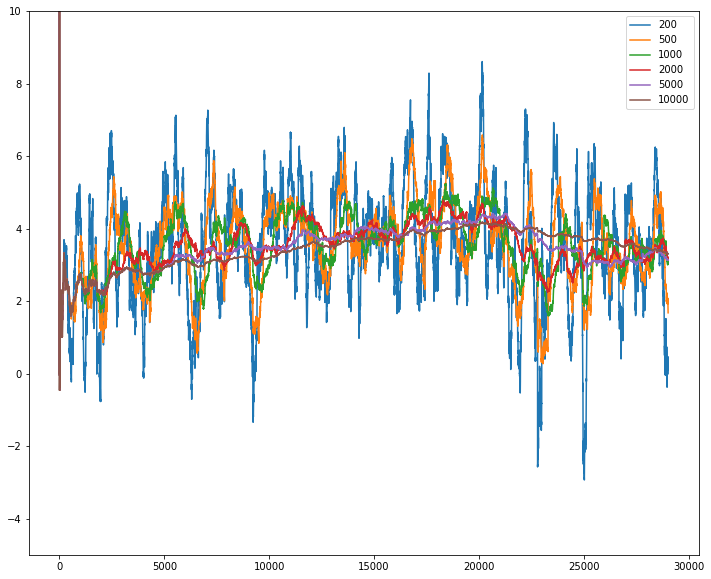

In [112]:
_ = compare_biases('2023-04-03', bias_dict_masked, test_dataframe)
plt.ylim(-5, 10);

Quantity weighted average with masking 

In [105]:
window_sizes = [200, 500, 1000, 2000, 5000, 10000]
windowed_biases_quantity_masked = []
for window in window_sizes:
    %time windowed_biases_quantity_masked.append(simulate_weighted_average(test_dataframe, 'quantity', 'error', groupby_cols = ['trade_date'], window_size = window, weighting_method = 'default', mask_large = 35))
    
bias_dict_quantity_masked = dict(zip(window_sizes, windowed_biases_quantity_masked))

CPU times: user 1min 40s, sys: 0 ns, total: 1min 40s
Wall time: 1min 40s
CPU times: user 1min 46s, sys: 0 ns, total: 1min 46s
Wall time: 1min 46s
CPU times: user 1min 39s, sys: 0 ns, total: 1min 39s
Wall time: 1min 38s
CPU times: user 1min 43s, sys: 0 ns, total: 1min 43s
Wall time: 1min 43s
CPU times: user 1min 47s, sys: 0 ns, total: 1min 47s
Wall time: 1min 47s
CPU times: user 1min 56s, sys: 0 ns, total: 1min 56s
Wall time: 1min 56s


Window Size: 200
Original bias: 0.451, Original MAE: 9.531, Corrected bias: 0.000, Corrected MAE: 9.380

Window Size: 500
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.004, Corrected MAE: 9.341

Window Size: 1000
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.013, Corrected MAE: 9.327

Window Size: 2000
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.032, Corrected MAE: 9.319

Window Size: 5000
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.082, Corrected MAE: 9.316

Window Size: 10000
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.179, Corrected MAE: 9.321



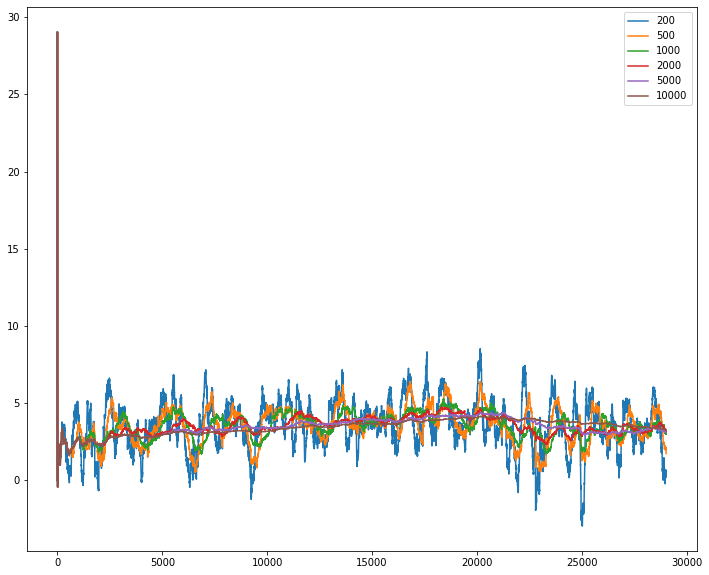

In [111]:
_ = compare_biases('2023-04-03', bias_dict_quantity_masked, test_dataframe)

Mask Size:

In [140]:
mask_sizes = [10, 20, 35, 50, 100, 0]
windowed_biases_quantity_masked_variants = []
for mask_size in mask_sizes:
    %time windowed_biases_quantity_masked_variants.append(simulate_weighted_average(test_dataframe, 'quantity', 'error', groupby_cols = ['trade_date'], window_size = 2000, weighting_method = 'default', mask_large = mask_size))
    
bias_dict_quantity_masked_variants = dict(zip(mask_sizes, windowed_biases_quantity_masked_variants))

Ignoring trades with errors larger than 10bps in bias correction calculations.
CPU times: user 2min, sys: 24.5 ms, total: 2min
Wall time: 2min
Ignoring trades with errors larger than 20bps in bias correction calculations.
CPU times: user 1min 55s, sys: 14.9 ms, total: 1min 55s
Wall time: 1min 55s
Ignoring trades with errors larger than 35bps in bias correction calculations.
CPU times: user 1min 54s, sys: 42.6 ms, total: 1min 54s
Wall time: 1min 54s
Ignoring trades with errors larger than 50bps in bias correction calculations.
CPU times: user 1min 54s, sys: 50 ms, total: 1min 54s
Wall time: 1min 54s
Ignoring trades with errors larger than 100bps in bias correction calculations.
CPU times: user 1min 56s, sys: 14.8 ms, total: 1min 56s
Wall time: 1min 56s
CPU times: user 1min 39s, sys: 33.7 ms, total: 1min 39s
Wall time: 1min 39s


In [244]:
bias_dict_quantity_masked_variants = dict(zip(mask_sizes, 
                                             [np.nan_to_num(np.array(bias)) for bias in windowed_biases_quantity_masked_variants]))

bias_dict_quantity_masked_variants_warm = dict(zip(mask_sizes, 
                                             [np.nan_to_num(np.array(bias_warm_start(bias, test_dataframe, 200))) for bias in windowed_biases_quantity_masked_variants]))

Window Size: 10
Original bias: 0.451, Original MAE: 9.531, Corrected bias: 0.529, Corrected MAE: 9.335

Window Size: 20
Original bias: 0.451, Original MAE: 9.531, Corrected bias: 0.339, Corrected MAE: 9.263

Window Size: 35
Original bias: 0.451, Original MAE: 9.531, Corrected bias: 0.190, Corrected MAE: 9.264

Window Size: 50
Original bias: 0.451, Original MAE: 9.531, Corrected bias: 0.088, Corrected MAE: 9.284

Window Size: 100
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.051, Corrected MAE: 9.313

Window Size: 0
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.032, Corrected MAE: 9.319



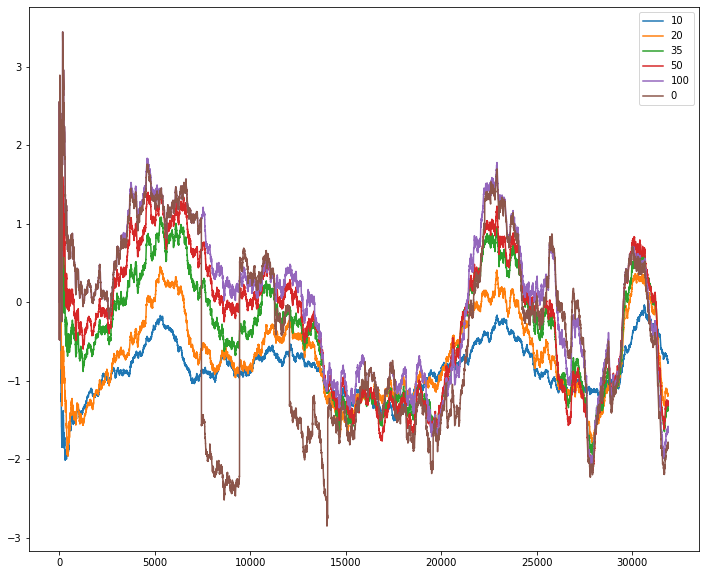

In [274]:
mask_summary = compare_biases('2023-04-27', bias_dict_quantity_masked_variants, test_dataframe)

Window Size: 10
Original bias: 0.451, Original MAE: 9.531, Corrected bias: 0.527, Corrected MAE: 9.335

Window Size: 20
Original bias: 0.451, Original MAE: 9.531, Corrected bias: 0.338, Corrected MAE: 9.262

Window Size: 35
Original bias: 0.451, Original MAE: 9.531, Corrected bias: 0.190, Corrected MAE: 9.263

Window Size: 50
Original bias: 0.451, Original MAE: 9.531, Corrected bias: 0.087, Corrected MAE: 9.283

Window Size: 100
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.050, Corrected MAE: 9.312

Window Size: 0
Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.031, Corrected MAE: 9.317



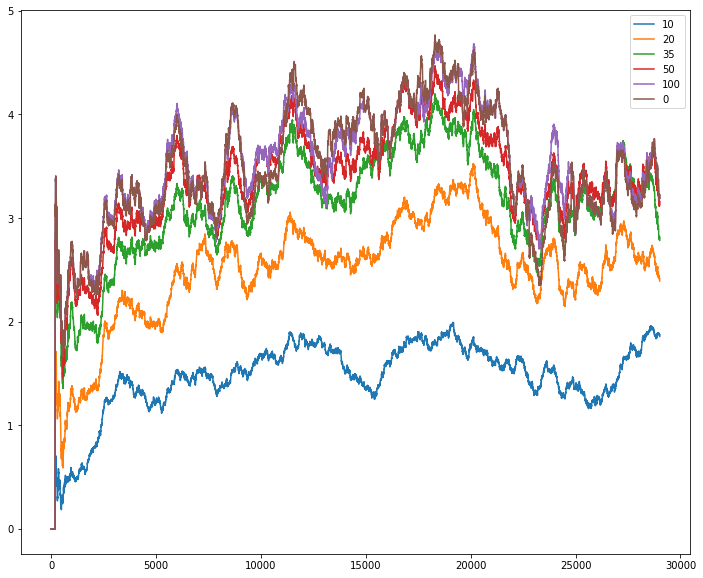

In [245]:
mask_summary = compare_biases('2023-04-03', bias_dict_quantity_masked_variants_warm, test_dataframe)

Comparing masking and no masking on days with extremely large errors:

In [257]:
display(test_dataframe[['cusip','trade_datetime','error']].sort_values(by='error', ascending=False).head(5))
display(test_dataframe[['cusip','trade_datetime','error']].sort_values(by='error', ascending=False).tail(5))

,cusip,trade_datetime,error
111429,406511AL9,2023-04-06 14:08:33,403.440
273275,74442HAT0,2023-04-17 09:25:12,312.733
418626,64579F6J7,2023-04-21 13:13:53,242.283
160608,3042432H0,2023-04-11 12:09:33,241.967
365959,041807AQ1,2023-04-19 15:51:11,222.143


,cusip,trade_datetime,error
216950,084538HT7,2023-04-13 10:25:17,-984.114
216953,084538HT7,2023-04-13 10:25:17,-994.937
535981,084538HS9,2023-04-27 12:11:08,-2021.386
531366,084538HS9,2023-04-27 11:16:51,-2136.203
531364,084538HS9,2023-04-27 11:16:51,-2149.503


In [268]:
comp = pd.DataFrame(index = test_dataframe.trade_datetime)
comp['unmasked'] = bias_dict[2000]
comp['masked_35'] = error_average_bias_correction

<AxesSubplot:xlabel='trade_datetime'>

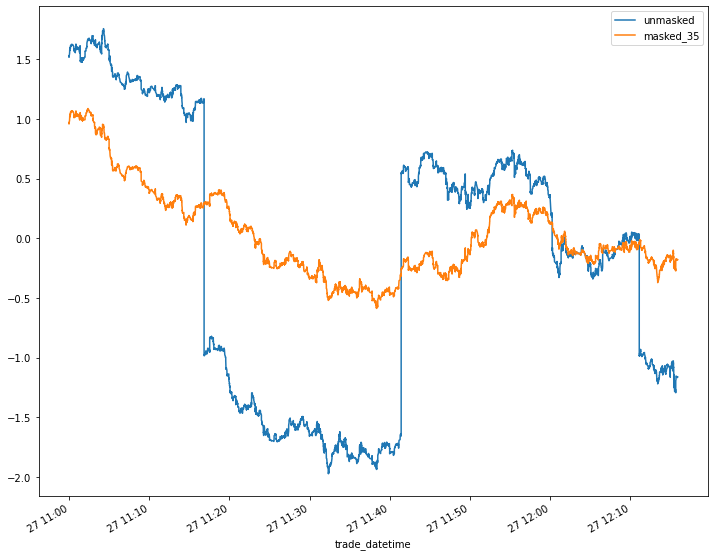

In [273]:
comp.loc['2023-04-27 11:00':'2023-04-27 12:15'].plot(figsize=(12,10))

In [294]:
analyze_debiasing_MAE(
    test_dataframe,
    np.nan_to_num(error_average_bias_correction,0),
    prediction_col='prediction',
    target_col='new_ys_realtime')

,Original MAE,Corrected MAE,Corrected - Original MAE
trade_date,,,
2023-04-03,8.475,7.974,-0.500
2023-04-04,8.566,8.342,-0.224
2023-04-05,8.296,8.303,0.007
2023-04-06,8.380,8.170,-0.210
2023-04-07,9.181,9.374,0.193
2023-04-10,8.776,8.773,-0.002
2023-04-11,8.837,8.831,-0.006
2023-04-12,8.771,8.724,-0.046
2023-04-13,8.591,8.598,0.006


In [298]:
analyze_debiasing_day('2023-04-27', 
                      test_dataframe, 
                      np.nan_to_num(bias_dict[2000],0) , 
                      prediction_col = 'prediction', 
                      target_col='new_ys_realtime', 
                      first_N_trades =  500, 
                      last_N_trades = 500,
                         print_graphs=False)

,cusip,rtrs_control_number,trade_date,trade_type,quantity,prediction,new_ys_realtime,bias_correction,debiased_prediction,original_error,debiased_error
trade_datetime,,,,,,,,,,,
2023-04-27 06:55:27,64972HXW7,2023042700009000,2023-04-27,S,4.929,35.423,32.873,0.000,35.423,-2.550,-2.550
2023-04-27 07:05:20,715036BG3,2023042700010000,2023-04-27,D,4.398,11.679,13.375,2.550,9.129,1.696,4.246
2023-04-27 07:05:20,715036BG3,2023042700009800,2023-04-27,S,4.398,14.000,13.375,0.427,13.573,-0.625,-0.198
2023-04-27 07:09:34,60375BLF1,2023042700016800,2023-04-27,D,5.097,-18.982,-23.121,0.493,-19.476,-4.139,-3.646
2023-04-27 07:09:34,60375BLF1,2023042700016600,2023-04-27,S,5.097,-17.891,-23.121,1.405,-19.295,-5.231,-3.826
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-27 17:14:50,728835K32,2023042711575000,2023-04-27,S,4.000,-26.132,-27.663,-1.806,-24.326,-1.531,-3.337
2023-04-27 17:14:52,728835K32,2023042711580900,2023-04-27,D,4.000,-18.901,-15.863,-1.779,-17.122,3.038,1.259
2023-04-27 17:17:15,441178DD9,2023042711596400,2023-04-27,S,4.301,135.379,104.547,-1.775,137.154,-30.831,-32.606


In [316]:
A = analyze_debiasing_day('2023-04-27', 
                      test_dataframe, 
                      np.nan_to_num(bias_dict[2000],0) , 
                      prediction_col = 'prediction', 
                      target_col='new_ys_realtime', 
                      first_N_trades =  500, 
                      last_N_trades = 500,
                         print_graphs=False).reset_index()[['rtrs_control_number', 'prediction', 'debiased_prediction', 'bias_correction', 'original_error','debiased_error', 'trade_datetime']]

B = analyze_debiasing_day('2023-04-27', 
                      test_dataframe, 
                      np.nan_to_num(error_average_bias_correction,0), 
                      prediction_col = 'prediction', 
                      target_col='new_ys_realtime', 
                      first_N_trades =  500, 
                      last_N_trades = 500,
                         print_graphs=False)[['rtrs_control_number', 'debiased_prediction',  'bias_correction', 'debiased_error']]

AB = pd.merge(A,B, left_on='rtrs_control_number', right_on='rtrs_control_number', suffixes = ('_unmasked','_masked_35')).set_index('trade_datetime')[['debiased_error_unmasked', 'debiased_error_masked_35']].applymap(np.abs).expanding(min_periods=1).mean()

<AxesSubplot:xlabel='trade_datetime'>

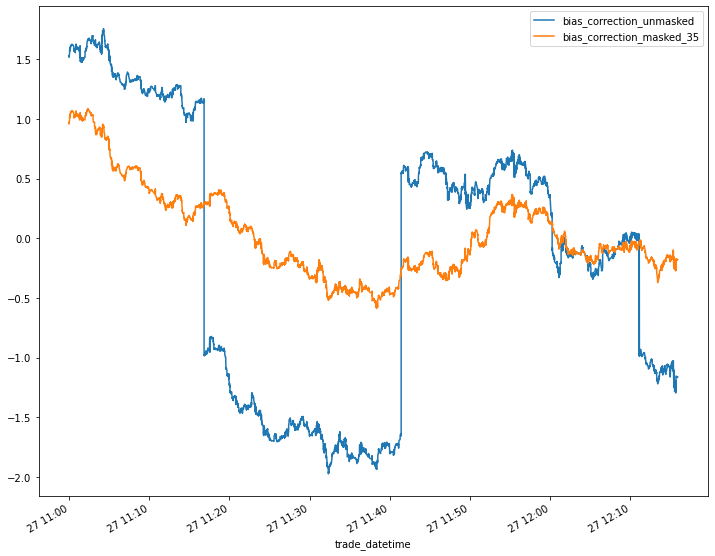

In [329]:
pd.merge(A,B, left_on='rtrs_control_number', right_on='rtrs_control_number', suffixes = ('_unmasked','_masked_35')).set_index('trade_datetime').loc['2023-04-27 11:00':'2023-04-27 12:15'][['bias_correction_unmasked', 'bias_correction_masked_35']].plot(figsize=(12,10))

<AxesSubplot:xlabel='trade_datetime'>

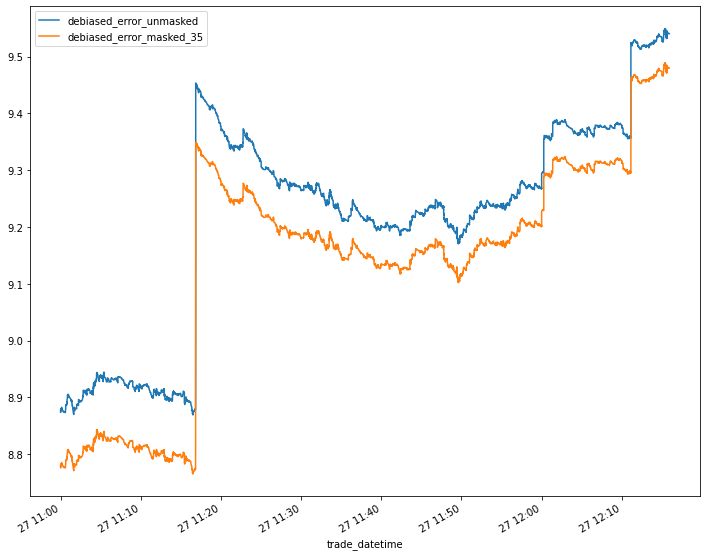

In [311]:
AB.loc['2023-04-27 11:00':'2023-04-27 12:15'].plot(figsize=(12,10))

Weighting with quantity and error:

Trying to weight by both quantity and error size, which are both intuitive, but the result is probably over-engineered and/or overfit. 

In [ ]:
def calculate_weighted_average_multiple(data, weighting_cols_dict, error_col, mask_large = 35):
    '''Calculates weighted average of error_col based on weighting_col
    
    If weighted average is to be calculated based on error magnitude, weighting_col should be set to error_col. 
    Different ways of calculating the weighted average are dictated by the method kwarg.
    '''
    from numpy.linalg import multi_dot
    
    data = data.iloc[:-1]
    if len(data) == 0: return 0 
        
    errors = data[error_col].to_numpy().flatten()
    weights = []
    
    for weighting_col, method in weighting_cols_dict.items():
        weight = data[weighting_col].to_numpy().flatten()

        if method == 'default':
            pass
        if method == 'reciprocal':
            weight = np.abs(1/weight)
        if method == 'log':
            weight = np.log(np.abs(weight) + 1)
        if method == 'log_reciprocal':
            weight = np.log(np.abs(1/weight)) 
        
        weights.append(weight)
        
    if mask_large:
        weights[0] = np.where(np.abs(errors) <= mask_large , weights[0], 0)
    
    weights = np.prod(np.vstack(weights), axis=0)
    
    return np.dot(weights, errors)/np.sum(weights)

In [208]:
def simulate_weighted_average_multiple(df, weighting_cols_dict, error_col, groupby_cols = ['trade_date'], window_size = 2000, mask_large = 35):
    '''Simulates debiasing procedure in production by calculating rolling average bias 
    
    Window_size dictates the N preceding trades to estimate bias correction for each row. 
    Setting window_size larger than the dataframe is equivalent to using pd.expanding(). 
    '''
    
    #if we are weigthing by the error column then don't slice the column twice
    subset = list(weighting_cols_dict.keys())
    if error_col not in weighting_cols_dict:
        subset += [error_col] 
    print(subset)
    
    if window_size > len(df): window_size = len(df)
    groupby_dfs = list(df.groupby(groupby_cols)[subset].rolling(window_size, method='table'))
    
    biases = []
    if mask_large:
        print(f'Ignoring trades with errors larger than {mask_large}bps in bias correction calculations.')
        
    for sub_df in groupby_dfs:
        biases.append(calculate_weighted_average_multiple(sub_df, weighting_cols_dict, error_col, mask_large = mask_large))
    
    return biases 

In [226]:
%time quantity_error_default_bias_correction = simulate_weighted_average_multiple(test_dataframe, {'quantity': 'default', 'error': 'log'}, 'error', groupby_cols = ['trade_date'], window_size = 2000, mask_large = 35)

['quantity', 'error']
Ignoring trades with errors larger than 35bps in bias correction calculations.


../../ficc_debiasing.py:163: RuntimeWarning: invalid value encountered in double_scalars
  


CPU times: user 3min 3s, sys: 19.3 ms, total: 3min 3s
Wall time: 3min 3s


In [247]:
debias_series(test_dataframe['prediction'], test_dataframe[target_variable], np.nan_to_num(np.array(quantity_error_default_bias_correction)))   

Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.128, Corrected MAE: 9.376


In [251]:
debias_series(test_dataframe['prediction'], test_dataframe[target_variable], np.nan_to_num(np.array(bias_warm_start(quantity_error_default_bias_correction, test_dataframe, 200))))   

Original bias: 0.451, Original MAE: 9.531, Corrected bias: -0.127, Corrected MAE: 9.372
